# Regression data using scikit-learn

Regression is when the feature to be predicted contains continuous values. Regression refers to the process of predicting a dependent variable by analyzing the relationship between other independent variables. There are several algorithms known to us that help us in excavating these relationships to better predict the value.

In this notebook, we'll use scikit-learn to predict values. Scikit-learn provides implementations of many regression algorithms. In here, we have done a comparative study of 5 different regression algorithms. 

To help visualize what we are doing, we'll use 2D and 3D charts to show how the classes looks (with 3 selected dimensions) with matplotlib and seaborn python libraries.


<a id="top"></a>
## Table of Contents

1. [Load libraries](#load_libraries)
2. [Helper methods for metrics](#helper_methods)
3. [Data exploration](#explore_data)
4. [Prepare data for building regression model](#prepare_data)
5. [Build Simple Linear Regression model](#model_slr)
6. [Build Multiple Linear Regression classification model](#model_mlr)
7. [Build Polynomial Linear Regression model](#model_plr) 
8. [Build Decision Tree Regression model](#model_dtr) 
9. [Build Random Forest Regression model](#model_rfr)
10. [Comparitive study of different regression algorithms](#compare_classification)

### Quick set of instructions to work through the notebook

If you are new to Notebooks, here's a quick overview of how to work in this environment.

1. The notebook has 2 types of cells - markdown (text) such as this and code such as the one below. 
2. Each cell with code can be executed independently or together (see options under the Cell menu). When working in this notebook, we will be running one cell at a time because we need to make code changes to some of the cells.
3. To run the cell, position cursor in the code cell and click the Run (arrow) icon. The cell is running when you see the * next to it. Some cells have printable output.
4. Work through this notebook by reading the instructions and executing code cell by cell. Some cells will require modifications before you run them. 

<a id="load_libraries"></a>
## 1. Load libraries
[Top](#top)

 It is convention to import all of your python libraries at the top of the file. While it is possible to import the libraries at any point in a python notebook, doing so in all in one place makes it easy to figure out where the symbols are coming from.

In [1]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_squared_error, r2_score

import pandas as pd, numpy as np
import sys
import io

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.tree import export_graphviz



<a id="helper_methods"></a>
## 2. Helper methods for metrics
[Top](#top)

One of the benefits of using Python to do data science is that you can simplify your work by defining repetitive tasks as functions (or methods as they are called in Python).

In the following section, we define three methods that will help us with the repetitive tasks throughout.

In [5]:

def two_d_compare(X_test,y_test,y_pred,model_name):
    '''
    Plot the predicted values and actual values on two side-by-side plots.

    :param X_test: A series containing the X values.
    :param y_test: A series containing the actual Y values corresponding to X_test entries.
    :param y_pred: A series containing the predicted Y values corresponding to X_test entries.
    :param model_name: name of the model. Used for placing in the plot's title.
    '''

    # Defining a plot with two subplots
    plt.subplots(ncols=2, figsize=(10,4))

    # Naming the plots
    plt.suptitle('Actual vs Predicted data : ' +model_name + '. Variance score: %.2f' % r2_score(y_test, y_pred))

    # Populating the first subplot
    plt.subplot(121)
    plt.scatter(X_test, y_test, alpha=0.8, color='#8CCB9B')
    plt.title('Actual')

    # Populating the second subplot
    plt.subplot(122)
    plt.scatter(X_test, y_pred,alpha=0.8, color='#E5E88B')
    plt.title('Predicted')

    # directive to display the created plot
    plt.show()
    

def model_metrics(y_test,y_pred):
    '''
    Calculate MSE and R2 errors, print them, and return them as a list.append

    :param y_test: A series containing the actual Y values
    :param y_pred: A series containing the predicted Y values
    '''

    # Calculate and print Mean Squared Error (MSE)
    mse = mean_squared_error(y_test,y_pred)
    print("Mean squared error: %.2f" % mse)
    
    # Calculate and print R^2 
    r2 = r2_score(y_test, y_pred)
    print('R2 score: %.2f' % r2 )
    
    return [mse, r2]

def two_vs_three(x_test,y_test,y_pred,z=None, isLinear = False) : 
    '''
    Create a 3D plot of LOT AREA vs YEAR BUILT vs SELLING PRICE.

    Technically this function creates a 3-D scatterplot, however, in this 
    notebook we've only used it to generate the three plot mentioned above.

    :param x_test: A series containing the x values
    :param y_test: A series containing the actual Y values
    :param y_pred: A series containing the predicted Y values
    '''
    
    area = 60
    
    # Define the size of the graph and it's title
    fig = plt.figure(figsize=(12,6))
    fig.suptitle('2D and 3D view of sales price data')

    # First subplot
    ax = fig.add_subplot(1, 2,1)
    ax.scatter(x_test, y_test, alpha=0.5,color='blue', s= area)
    ax.plot(x_test, y_pred, alpha=0.9,color='red', linewidth=2)
    ax.set_xlabel('YEAR BUILT')
    ax.set_ylabel('SELLING PRICE')
    
    plt.title('YEARBUILT vs SALEPRICE')
    
    if not isLinear : 
    # Second subplot
        ax = fig.add_subplot(1,2,2, projection='3d')

        ax.scatter(z, x_test, y_test, color='blue', marker='o')
        ax.plot(z, x_test, y_pred, alpha=0.9,color='red', linewidth=2)
        ax.set_ylabel('YEAR BUILT')
        ax.set_zlabel('SELLING PRICE')
        ax.set_xlabel('LOT AREA')

    plt.title('LOT AREA vs YEAR BUILT vs SELLING PRICE')

    plt.show()
    

<a id="explore_data"></a>
## 3. Data exploration
[Top](#top)

Data can be easily loaded within IBM Watson Studio. Instructions to load data within IBM Watson Studio can be found [here](https://ibmdev1.rtp.raleigh.ibm.com/tutorials/watson-studio-using-jupyter-notebook/). The data set can be located by its name and inserted into the notebook as a pandas DataFrame as shown below.

![insert_spark_dataframe.png](https://raw.githubusercontent.com/IBM/icp4d-customer-churn-classifier/master/doc/source/images/insert_spark_dataframe.png)

The generated code comes up with a generic name and it is good practice to rename the dataframe to match the use case context.


To simplify this notebook, we will use a feature of Pandas that allows us to directly load a csv file from the internet. You can use the instruction above if you want to load your own dataset.


### About the Data
The data that we are loading contains housing related information. With several independent variables related to this domain, we are going to predict the sales price of a house. 

In [6]:
# Load the Data
df_pd =  pd.read_csv("https://raw.githubusercontent.com/IBM/ml-learning-path-assets/master/data/predict_home_value.csv")

# Show the first 5 rows of the data.
# Good for quick inspection of the data and column names.
df_pd.head()

,ID,LOTAREA,BLDGTYPE,HOUSESTYLE,OVERALLCOND,YEARBUILT,ROOFSTYLE,EXTERCOND,FOUNDATION,BSMTCOND,...,GARAGETYPE,GARAGEFINISH,GARAGECARS,GARAGECOND,POOLAREA,POOLQC,FENCE,MOSOLD,YRSOLD,SALEPRICE
0,1,8450,1Fam,2Story,5,2003,Gable,TA,PConc,TA,...,Attchd,RFn,2,TA,0,NaN,NaN,2,2008,208500
1,2,9600,1Fam,1Story,8,1976,Gable,TA,CBlock,TA,...,Attchd,RFn,2,TA,0,NaN,NaN,5,2007,181500
2,3,11250,1Fam,2Story,5,2001,Gable,TA,PConc,TA,...,Attchd,RFn,2,TA,0,NaN,NaN,9,2008,223500
3,4,9550,1Fam,2Story,5,1915,Gable,TA,BrkTil,Gd,...,Detchd,Unf,3,TA,0,NaN,NaN,2,2006,140000
4,5,14260,1Fam,2Story,5,2000,Gable,TA,PConc,TA,...,Attchd,RFn,3,TA,0,NaN,NaN,12,2008,250000


<AxesSubplot:xlabel='YEARBUILT', ylabel='SALEPRICE'>

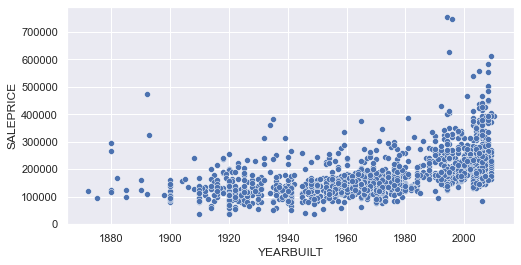

In [22]:
x = df_pd['YEARBUILT']
y = df_pd['SALEPRICE']

sns.scatterplot(x = x, y =y)

## Exercise 1

Let's practice our plotting. Create a scatter plot of the lot area versus the sales price. Do you see any trend?

**Hint:** Print the column names first if you don't know the name. Note that you can plot only numerical columns (`int64` in this case)

In [29]:
# Your Answer:

# Uncomment the line below if you need the column names
# df_pd.dtypes



In [30]:
# Solution 

%load

UsageError: Missing filename, URL, input history range, macro, or element in the user namespace.


 Next, let's take a look at creating histograms using `seaborn`. Note that the `histplot` functionality of Seaborn has many options, in this case we are enabling the KDE by adding `kde = True` to show a add a kernel density estimate to smooth the distribution.


 See [histplot documentation](https://seaborn.pydata.org/generated/seaborn.histplot.html) to learn about the other options.

<AxesSubplot:xlabel='SALEPRICE', ylabel='Count'>

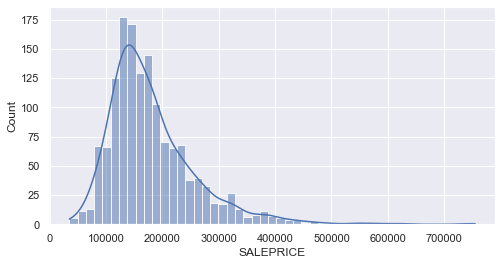

In [36]:
sns.histplot(df_pd['SALEPRICE'], kde=True)

In [37]:

print("The dataset contains columns of the following data types : \n" +str(df_pd.dtypes))


The dataset contains columns of the following data types : 
ID               int64
LOTAREA          int64
BLDGTYPE        object
HOUSESTYLE      object
OVERALLCOND      int64
YEARBUILT        int64
ROOFSTYLE       object
EXTERCOND       object
FOUNDATION      object
BSMTCOND        object
HEATING         object
HEATINGQC       object
CENTRALAIR      object
ELECTRICAL      object
FULLBATH         int64
HALFBATH         int64
BEDROOMABVGR     int64
KITCHENABVGR     int64
KITCHENQUAL     object
TOTRMSABVGRD     int64
FIREPLACES       int64
FIREPLACEQU     object
GARAGETYPE      object
GARAGEFINISH    object
GARAGECARS       int64
GARAGECOND      object
POOLAREA         int64
POOLQC          object
FENCE           object
MOSOLD           int64
YRSOLD           int64
SALEPRICE        int64
dtype: object


### Missing Values
Notice below that FIREPLACEQU, GARAGETYPE, GARAGEFINISH, GARAGECOND,FENCE and POOLQC have missing values. 

**Important:** It is important to take care of missing data before feeding the data into your ML model. Most Regression Algorithms cannot handle missing values, so it is on you to decide what to do with them before feeding the data.

You could, for instance, remove those rows, fill them in with the average of the colum, interpolate based on other rows, or any other statistical method. Nontheless, you should handle missing values (`NaN` or Not a Number) first.

In [43]:
# Place True for each cell if the value is missing and False if a value is present
missing_values = df_pd.isna()

# Since True is a 1 and False is a 0, by summing each column, we effectively count the number of Trues 
# which is equal to the count of missing values.

print("The dataset contains following number of records for each of the columns : \n" + str(missing_values_count) )


The dataset contains following number of records for each of the columns : 
ID                 0
LOTAREA            0
BLDGTYPE           0
HOUSESTYLE         0
OVERALLCOND        0
YEARBUILT          0
ROOFSTYLE          0
EXTERCOND          0
FOUNDATION         0
BSMTCOND          37
HEATING            0
HEATINGQC          0
CENTRALAIR         0
ELECTRICAL         1
FULLBATH           0
HALFBATH           0
BEDROOMABVGR       0
KITCHENABVGR       0
KITCHENQUAL        0
TOTRMSABVGRD       0
FIREPLACES         0
FIREPLACEQU      690
GARAGETYPE        81
GARAGEFINISH      81
GARAGECARS         0
GARAGECOND        81
POOLAREA           0
POOLQC          1453
FENCE           1179
MOSOLD             0
YRSOLD             0
SALEPRICE          0
dtype: int64


Alternatively, you can use the following code to simply indicate if there are *any* missing values in each column. By the time you start your machine learning experiment, you want to have Falses for every column that is used in the model.


In [46]:
# Show if there are any missing values in each column
df_pd.isnull().any()

ID              False
LOTAREA         False
BLDGTYPE        False
HOUSESTYLE      False
OVERALLCOND     False
YEARBUILT       False
ROOFSTYLE       False
EXTERCOND       False
FOUNDATION      False
BSMTCOND         True
HEATING         False
HEATINGQC       False
CENTRALAIR      False
ELECTRICAL       True
FULLBATH        False
HALFBATH        False
BEDROOMABVGR    False
KITCHENABVGR    False
KITCHENQUAL     False
TOTRMSABVGRD    False
FIREPLACES      False
FIREPLACEQU      True
GARAGETYPE       True
GARAGEFINISH     True
GARAGECARS      False
GARAGECOND       True
POOLAREA        False
POOLQC           True
FENCE            True
MOSOLD          False
YRSOLD          False
SALEPRICE       False
dtype: bool

<a id="prepare_data"></a>
## 4. Data preparation
[Top](#top)

Data preparation is a very important step in machine learning model building. This is because the model can perform well only when the data it is trained on is good and well prepared. Hence, this step consumes bulk of data scientist's time spent building models.

During this process, we identify categorical columns in the dataset. Categories needed to be indexed, which means the string labels are converted to label indices. These label indices are encoded using One-hot encoding to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values. This encoding allows algorithms which expect continuous features to use categorical features.


We begin by identifying columns that will not add any value toward predicting the outputs. While some of these columns are easily identified, a subject matter expert is usually engaged to identify most of them. Removing such columns helps in reducing dimensionality of the model.

In [49]:
#remove columns that are not required
df_pd = df_pd.drop(['ID'], axis=1)

df_pd.head()


KeyError: "['ID'] not found in axis"

The preprocessing techniques that are applied must be customized for each of the columns. Sklearn provides a library called the ColumnTransformer, which allows a sequence of these techniques to be applied to selective columns using a pipeline.


A common problem while dealing with data sets is that values will be missing. scikit-learn provides a method to fill these empty values with something that would be applicable in its context. We used the SimpleImputer class that is provided by Sklearn and filled the missing values with the most frequent value in the column.


Also, because machine learning algorithms perform better with numbers than with strings, we want to identify columns that have categories and convert them into numbers. We use the OneHotEncoder class provided by Sklearn. The idea of one hot encoder is to create binary variables that each represent a category. By doing this, we remove any ordinal relationship that might occur by just assigning numbers to categories. Basically, we go from a single column that contains multiple class numbers to multiple columns that contain only binary class numbers.

In [53]:
# Defining the categorical columns 
categoricalColumns = df_pd.select_dtypes(include=[object]).columns

print("Categorical columns : " )
print(categoricalColumns)

impute_categorical = SimpleImputer(strategy="most_frequent")
onehot_categorical =  OneHotEncoder(handle_unknown='ignore')

categorical_transformer = Pipeline(steps=[('impute',impute_categorical),('onehot',onehot_categorical)])

Categorical columns : 
Index(['BLDGTYPE', 'HOUSESTYLE', 'ROOFSTYLE', 'EXTERCOND', 'FOUNDATION',
       'BSMTCOND', 'HEATING', 'HEATINGQC', 'CENTRALAIR', 'ELECTRICAL',
       'KITCHENQUAL', 'FIREPLACEQU', 'GARAGETYPE', 'GARAGEFINISH',
       'GARAGECOND', 'POOLQC', 'FENCE'],
      dtype='object')


The numerical columns from the data set are identified, and StandardScaler is applied to each of the columns. This way, each value is subtracted with the mean of its column and divided by its standard deviation.

In [52]:
# Defining the numerical columns 
numericalColumns = [col for col in df_pd.select_dtypes(include=[float,int]).columns if col not in ['SALEPRICE']]
print("Numerical columns : " )
print(numericalColumns)

scaler_numerical = StandardScaler()

numerical_transformer = Pipeline(steps=[('scale',scaler_numerical)])


Numerical columns : 
['LOTAREA', 'OVERALLCOND', 'YEARBUILT', 'FULLBATH', 'HALFBATH', 'BEDROOMABVGR', 'KITCHENABVGR', 'TOTRMSABVGRD', 'FIREPLACES', 'GARAGECARS', 'POOLAREA', 'MOSOLD', 'YRSOLD']


As discussed previously, each of the techniques are grouped by the columns they needed to be applied on and are queued using the ColumnTransformer. Ideally, this is run in the pipeline just before the model is trained. However, to understand what the data will look like, we have transformed the data into a temporary variable.

In [56]:
preprocessorForCategoricalColumns = ColumnTransformer(transformers=[('cat', categorical_transformer, categoricalColumns)],
                                            remainder="passthrough")
preprocessorForAllColumns = ColumnTransformer(transformers=[('cat', categorical_transformer, categoricalColumns),('num',numerical_transformer,numericalColumns)],
                                            remainder="passthrough")


#. The transformation happens in the pipeline. Temporarily done here to show what intermediate value looks like
df_pd_temp = preprocessorForCategoricalColumns.fit_transform(df_pd)
print("Data after transforming :")
print(df_pd_temp)

df_pd_temp_2 = preprocessorForAllColumns.fit_transform(df_pd)
print("Data after transforming :")
print(df_pd_temp_2)

Data after transforming :
[[1.00000e+00 0.00000e+00 0.00000e+00 ... 2.00000e+00 2.00800e+03
  2.08500e+05]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 5.00000e+00 2.00700e+03
  1.81500e+05]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 9.00000e+00 2.00800e+03
  2.23500e+05]
 ...
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 5.00000e+00 2.01000e+03
  2.66500e+05]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 4.00000e+00 2.01000e+03
  1.42125e+05]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 6.00000e+00 2.00800e+03
  1.47500e+05]]
Data after transforming :
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.59911110e+00
   1.38777489e-01  2.08500000e+05]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.89110051e-01
  -6.14438622e-01  1.81500000e+05]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  9.90891347e-01
   1.38777489e-01  2.23500000e+05]
 ...
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.89110051e-01
   1.64520971e+00  2.66500000e+05]
 [ 1.00000000e+00  0.00000000e+

In [57]:
# Exercise
# 
# Use the hist plot to plot one of the numerical variables before and after the pre-processing to see how the transformation impacted it






In [58]:
# Answer 

%load 

UsageError: Missing filename, URL, input history range, macro, or element in the user namespace.


Machine learning algorithms cannot use simple text. We must convert the data from text to a number. Therefore, for each string that is a class we assign a label that is a number. For example, in the customer churn data set, the CHURNRISK output label is classified as high, medium, or low and is assigned labels 0, 1, or 2. We use the LabelEncoder class provided by Sklearn for this.

In [59]:
# prepare data frame for splitting data into train and test datasets

features = []
features = df_pd.drop(['SALEPRICE'], axis=1)

label = pd.DataFrame(df_pd, columns = ['SALEPRICE']) 
#label_encoder = LabelEncoder()
label = df_pd['SALEPRICE']

#label = label_encoder.fit_transform(label)
print(" value of label : " + str(label))

 value of label : 0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SALEPRICE, Length: 1460, dtype: int64


These are some of the popular preprocessing steps that are applied on the data sets. You can get more information in Data preprocessing in detail.

<a id="model_slr"></a>
## 5. Simple linear regression
[Top](#top)

This is the most basic form of linear regression in which the variable to be predicted is dependent on only one other variable. This is calculated by using the formula that is generally used in calculating the slope of a line.

y = w0 + w1*x1

In the above equation, y refers to the target variable and x1 refers to the independent variable. w1 refers to the coeeficient that expresses the relationship between y and x1 is it also know as the slope. w0 is the constant cooefficient a.k.a the intercept. It refers to the constant offset that y will always be with respect to the independent variables.

Since simple linear regression assumes that output depends on only one variable, we are assuming that it depends on the YEARBUILT. Data is split up into training and test sets. 

In [60]:
X = features['YEARBUILT'].values.reshape(-1,1)
X_train_slr, X_test_slr, y_train_slr, y_test_slr = train_test_split(X,label , random_state=0)

print("Dimensions of datasets that will be used for training : Input features"+str(X_train_slr.shape)+ 
      " Output label" + str(y_train_slr.shape))
print("Dimensions of datasets that will be used for testing : Input features"+str(X_test_slr.shape)+ 
      " Output label" + str(y_test_slr.shape))

Dimensions of datasets that will be used for training : Input features(1095, 1) Output label(1095,)
Dimensions of datasets that will be used for testing : Input features(365, 1) Output label(365,)


In [62]:
from sklearn.linear_model import LinearRegression

model_name = 'Simple Linear Regression'

slRegressor = LinearRegression()

slRegressor.fit(X_train_slr,y_train_slr)

y_pred_slr= slRegressor.predict(X_test_slr)

print(slRegressor)

LinearRegression()


In [63]:
print('Intercept: \n',slRegressor.intercept_)
print('Coefficients: \n', slRegressor.coef_)

Intercept: 
 -2517567.3215381317
Coefficients: 
 [1368.99630631]


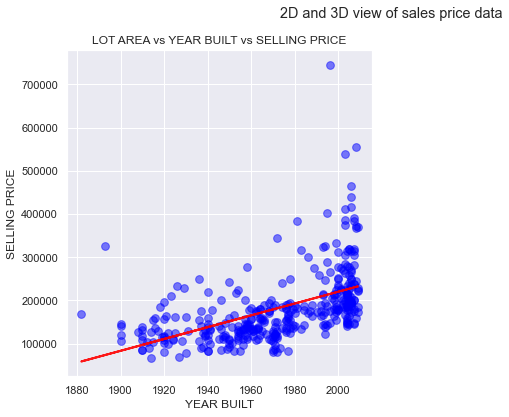

In [64]:
two_vs_three(X_test_slr[:,0],y_test_slr,y_pred_slr,None, True)  

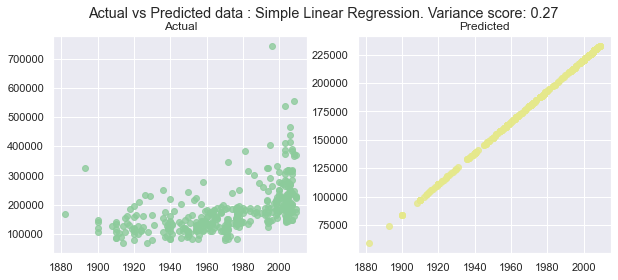

In [65]:
two_d_compare(X_test_slr,y_test_slr,y_pred_slr,model_name)

In [70]:
slrMetrics = model_metrics(y_test_slr,y_pred_slr)

Mean squared error: 4830018416.25
R2 score: 0.27


<a id="model_lrc"></a>
## 6. Build multiple linear regression model
[Top](#top)

Multiple linear regression is an extension to the simple linear regression. In this setup, the target value is dependant on more than one variable. The number of variables depends on the use case at hand. Usually a subject matter expert is involved in identifying the fields that will contribute towards better predicting the output feature.

y = w0 + w1*x1 + w2*x2 + .... + wn*xn

In [71]:
X_train, X_test, y_train, y_test = train_test_split(features,label , random_state=0)

print("Dimensions of datasets that will be used for training : Input features"+str(X_train.shape)+ 
      " Output label" + str(y_train.shape))
print("Dimensions of datasets that will be used for testing : Input features"+str(X_test.shape)+ 
      " Output label" + str(y_test.shape))

Dimensions of datasets that will be used for training : Input features(1095, 30) Output label(1095,)
Dimensions of datasets that will be used for testing : Input features(365, 30) Output label(365,)


In [72]:
from sklearn.linear_model import LinearRegression

model_name = 'Multiple Linear Regression'

mlRegressor = LinearRegression()

mlr_model = Pipeline(steps=[('preprocessorAll',preprocessorForAllColumns),('regressor', mlRegressor)])

mlr_model.fit(X_train,y_train)

y_pred_mlr= mlr_model.predict(X_test)

print(mlRegressor)

LinearRegression()


In [73]:
print('Intercept: \n',mlRegressor.intercept_)
print('Coefficients: \n', mlRegressor.coef_)

Intercept: 
 -4.401193698854283e+16
Coefficients: 
 [-4.36824728e+13 -4.36824728e+13 -4.36824728e+13 -4.36824728e+13
 -4.36824728e+13  1.81089340e+16  1.81089340e+16  1.81089340e+16
  1.81089340e+16  1.81089340e+16  1.81089340e+16  1.81089340e+16
  1.81089340e+16 -5.00134855e+16 -5.00134855e+16 -5.00134855e+16
 -5.00134855e+16 -5.00134855e+16 -5.00134855e+16  8.88853678e+15
  8.88853678e+15  8.88853678e+15  8.88853678e+15  8.88853678e+15
  3.09394494e+16  3.09394494e+16  3.09394494e+16  3.09394494e+16
  3.09394494e+16  3.09394494e+16  5.28265338e+15  5.28265338e+15
  5.28265338e+15  5.28265338e+15  4.60946978e+15  4.60946978e+15
  4.60946978e+15  4.60946978e+15  4.60946978e+15  4.60946978e+15
  1.86988701e+16  1.86988701e+16  1.86988701e+16  1.86988701e+16
  1.86988701e+16  1.38479213e+15  1.38479213e+15  1.31187702e+16
  1.31187702e+16  1.31187702e+16  1.31187702e+16  1.31187702e+16
  5.96897321e+15  5.96897321e+15  5.96897321e+15  5.96897321e+15
 -5.03906940e+15 -5.03906940e+15 -5.03

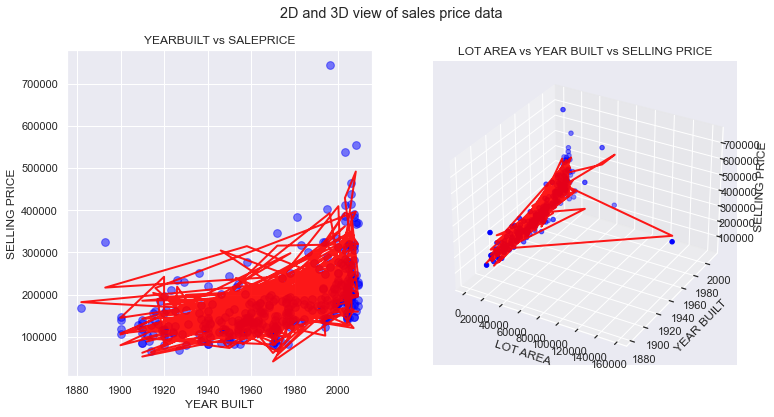

In [74]:
two_vs_three(X_test['YEARBUILT'],y_test,y_pred_mlr,X_test['LOTAREA'], False)  

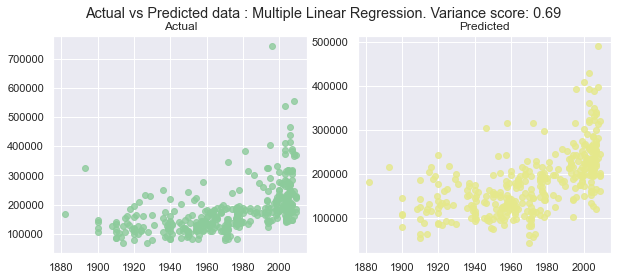

In [75]:
two_d_compare(X_test['YEARBUILT'],y_test,y_pred_mlr,model_name)

In [77]:
mlrMetrics = model_metrics(y_test,y_pred_mlr)

Mean squared error: 2041204630.38
R2 score: 0.69


<a id="model_plr"></a>
## 7. Build Polynomial Linear regression model
[Top](#top)

The prediction line generated by simple/linear regression is usually a straight line. In cases when a simple or multiple linear regression does not fit the data point accurately, we use the polynomial linear regression. The following formula is used in the back-end to generate polynomial linear regression.

y = w0 + w1*x1 + w2*x21 + .... + wn*xnn

We are assuming that output depends on the YEARBUILT and LOTATREA. Data is split up into training and test sets. 

In [78]:
X = features.iloc[:, [0,4]].values
X_train, X_test, y_train, y_test = train_test_split(X,label, random_state=0)

print("Dimensions of datasets that will be used for training : Input features"+str(X_train.shape)+ 
      " Output label" + str(y_train.shape))
print("Dimensions of datasets that will be used for testing : Input features"+str(X_test.shape)+ 
      " Output label" + str(y_test.shape))

Dimensions of datasets that will be used for training : Input features(1095, 2) Output label(1095,)
Dimensions of datasets that will be used for testing : Input features(365, 2) Output label(365,)


In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

model_name = 'Polynomial Linear Regression'

polynomial_features= PolynomialFeatures(degree=3)
plRegressor = LinearRegression()

plr_model = Pipeline(steps=[('polyFeature',polynomial_features ),('regressor', plRegressor)])

plr_model.fit(X_train,y_train)

y_pred_plr= plr_model.predict(X_test)

print(plRegressor)

LinearRegression()


In [80]:
print('Intercept: \n',plRegressor.intercept_)
print('Coefficients: \n', plRegressor.coef_)

Intercept: 
 7962298.221816668
Coefficients: 
 [ 0.00000000e+00  5.86665018e+03 -2.86476208e-01  1.21995579e-03
 -6.03747337e+00 -6.54540263e+00  2.54413388e-10 -6.61206782e-07
  1.55487110e-03  2.29375120e-03]


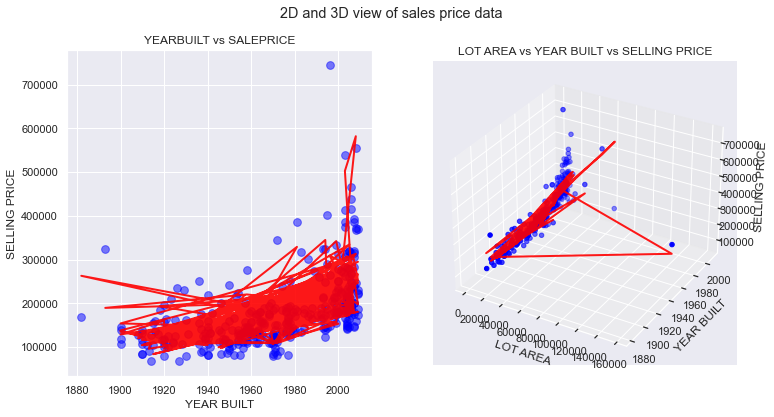

In [81]:
two_vs_three(X_test[:,1],y_test,y_pred_plr,X_test[:,0], False)  

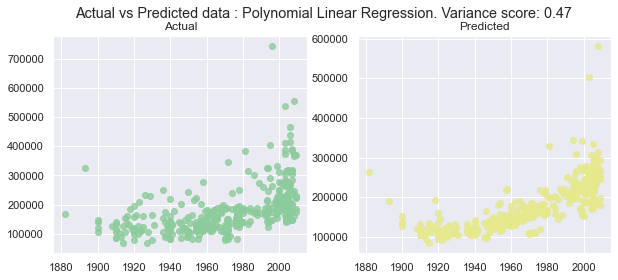

In [82]:
two_d_compare(X_test[:,1],y_test,y_pred_plr,model_name)

In [83]:
plrMetrics = model_metrics(y_test,y_pred_plr)

Mean squared error: 3514299577.83
R2 score: 0.47
